# 6002 Project

### Antoniadis Christoforos , Kontoudakis Nikolaos, Tsamoura Evgenia 

In [4]:
# import libraries
import seaborn as sns
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import mplfinance as mpf
import plotly.express as px
from sklearn.metrics import mean_absolute_error

from itertools import product
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from typing import List
from sklearn.metrics import mean_squared_error
%matplotlib inline
sns.set()

# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from sklearn.naive_bayes import BernoulliNB

warnings.filterwarnings('ignore')

In [5]:
# change the following on your pc!
projectPath = "/home/nikos/Documents/6002_project"
# projectPath = "C:/Users/Chris/Downloads"
dataPath = projectPath + "/smp500.csv"

In [6]:
smp500 = pd.read_csv(dataPath, sep= ',', header= 0, names=["date",	"open",	"high",	"low", "close",	"adj. close", "volume"])
smp500 = smp500.drop(columns = ["adj. close"])
smp500['date'] = pd.to_datetime(smp500['date'])

# set date as key
smp500= smp500.set_index(smp500['date']).to_period('D').drop(columns = 'date')
smp500

,open,high,low,close,volume
date,,,,,
2024-11-29,6003.98,6044.17,6003.98,6032.38,2444420000
2024-11-27,6014.11,6020.16,5984.87,5998.74,3363340000
2024-11-26,6000.03,6025.42,5992.27,6021.63,3835170000
2024-11-25,5992.28,6020.75,5963.91,5987.37,5633150000
2024-11-22,5944.36,5972.90,5944.36,5969.34,4141420000
...,...,...,...,...,...
2022-01-07,4697.66,4707.95,4662.74,4677.03,4181510000
2022-01-06,4693.39,4725.01,4671.26,4696.05,4295280000
2022-01-05,4787.99,4797.70,4699.44,4700.58,4887960000


### Data validation

In [8]:
print("There are %s na values" %(smp500.isna().sum().sum()))
print("There are %s zero values" % (smp500[smp500 == 0].sum(numeric_only=True).sum()))

# Check inconsistencies
# at every row low must be the lowest value
print("There are %s rows that the low of the row is higher than any other value" % (smp500[(smp500.low> smp500.high) & (smp500.low> smp500.close) & (smp500.low > smp500.open)].sum(numeric_only=True).sum()))

There are 0 na values
There are 0.0 zero values
There are 0.0 rows that the low of the row is higher than any other value


### Outlier Detection

In [10]:
#check the values of each row per specific column for outliers
def identifyOutliers(columnName):
    Zsmp500 = (smp500[columnName] - np.mean(smp500[columnName])) / np.std(smp500[columnName])
    return Zsmp500[(Zsmp500 > 3 ) | (Zsmp500 < -3 )].index
    
# run the function for every column
# smp500= smp500.drop(removeOutliers('open'), axis= 0).drop(removeOutliers('high'), axis= 0).drop(removeOutliers('low'), axis= 0).drop(removeOutliers('close'), axis= 0).drop(removeOutliers('volume'), axis= 0)

print(identifyOutliers('open'))
print(identifyOutliers('high'))
print(identifyOutliers('low'))
print(identifyOutliers('close'))
print(identifyOutliers('volume'))

PeriodIndex([], dtype='period[D]', name='date')
PeriodIndex([], dtype='period[D]', name='date')
PeriodIndex([], dtype='period[D]', name='date')
PeriodIndex([], dtype='period[D]', name='date')
PeriodIndex(['2024-09-20', '2024-06-28', '2024-06-21', '2024-03-15',
             '2023-12-15', '2023-09-15', '2023-06-16', '2023-03-17',
             '2022-12-16', '2022-09-16', '2022-06-24', '2022-06-17',
             '2022-05-31', '2022-03-18', '2022-03-08', '2022-03-07',
             '2022-02-24', '2022-01-24'],
            dtype='period[D]', name='date')


### Ploting

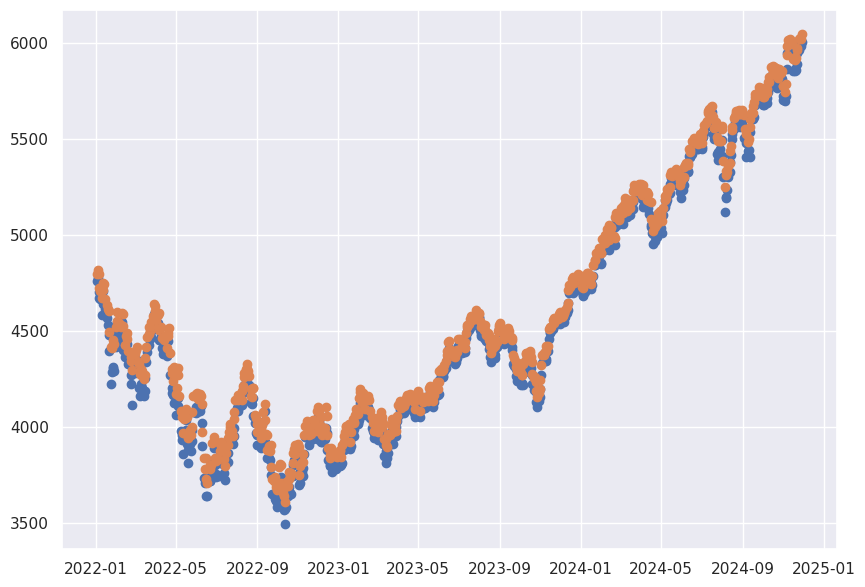

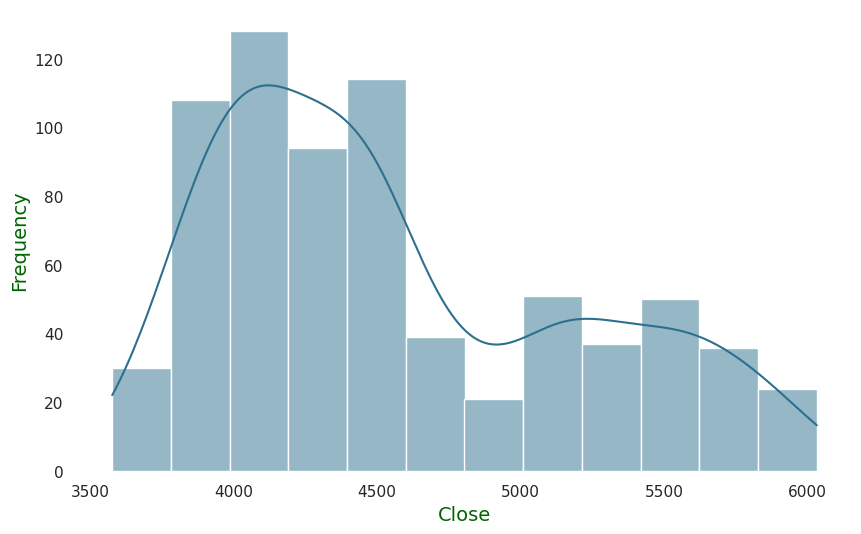

In [12]:
#scater plot
plt.figure(figsize=(10, 7))
plt.scatter(y= smp500.low, x =smp500.index.to_timestamp())
plt.scatter(y= smp500.high, x =smp500.index.to_timestamp())

# histogram
sns.set(style="white")
colors = sns.color_palette("viridis", n_colors=10)

# plotting the SAT score distribution using Seaborn with a KDE (Kernel Density Estimate) plot
plt.figure(figsize=(10, 6))
# sns.histplot(smp500.open, kde=True, color=colors[0])
# sns.histplot(smp500.close, kde=True, color=colors[1])
# sns.histplot(smp500.high, kde=True, color=colors[2])
sns.histplot(smp500.close, kde=True, color=colors[3])
# sns.histplot(smp500.volume, kde=True, color=colors[3])

# Remove left and bottom spines to eliminate the box
sns.despine(left=True, bottom=True)

# set the title and labels
# plt.title("SAT Score Distribution", fontsize=18, color='darkgreen')
plt.xlabel("Close", fontsize=14, color='darkgreen')
plt.ylabel("Frequency", fontsize=14, color='darkgreen')


# display the plot
plt.show()

In [13]:
df = smp500.copy()

In [14]:
# Check numerical columns
num_cols = df.describe(exclude='object') #check numerical columns only
col_names = num_cols.columns # we are using these numerical columns for visualizing our boxplot
# col_names

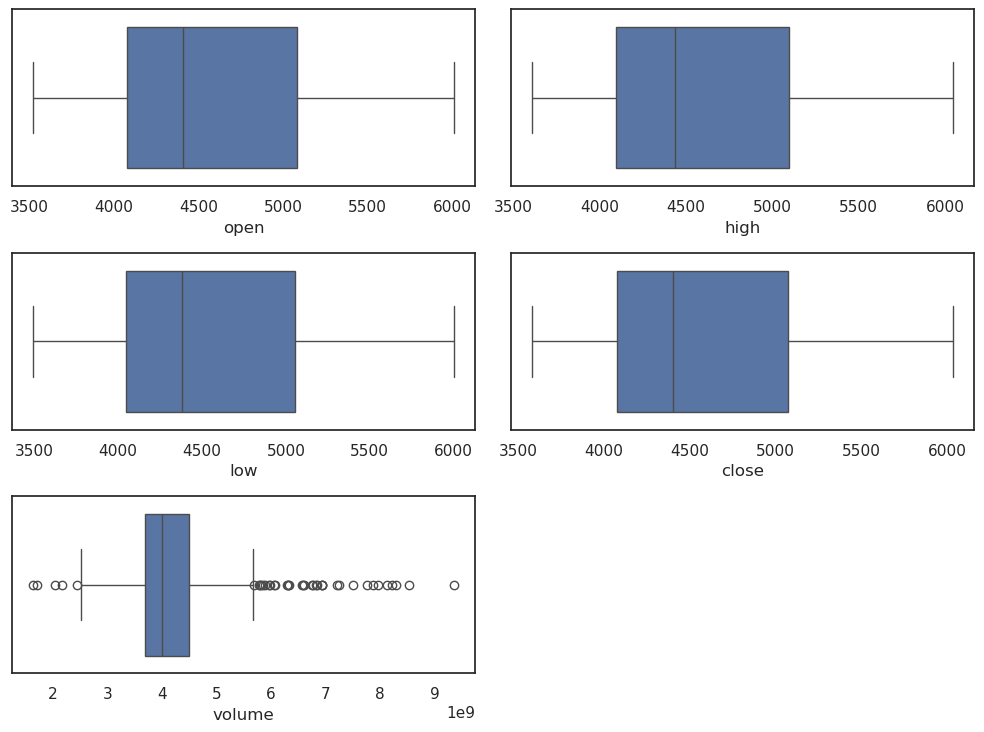

In [15]:
# Boxplot
fig = plt.figure(figsize=(10,7))

for i in range(5): #for 6 columns
    fig.tight_layout()
    
    grid_col = "32{}".format(i+1)
    
    ax = fig.add_subplot(int(grid_col))
    
    sns.boxplot(data=smp500, x=col_names[i], ax=ax)
    
plt.show()

In [16]:
# mpf.plot(df, type ='line', volume = True, tight_layout = True, style = 'yahoo')

In [17]:
# Seasonal decompose
# Source: https://regenerativetoday.com/how-to-detect-seasonality-in-the-time-series-data-and-remove-seasonality-in-python/

# df_month = pd.DataFrame(df.groupby(df.index.to_period('m'))['low'].mean())
# df_month.index = df_month.index.to_timestamp()
# res = sm.tsa.seasonal_decompose(df_month['low'])
# resplot = res.plot()

# Q2

In [19]:
firstPredictionRange = smp500[(smp500.index >= '2022-02-01')&(smp500.index < '2023-01-01')]
first_year = smp500.drop(columns = ['volume'])[(smp500.index >= '2022-01')&(smp500.index < '2023-01')]
firstEleven = first_year[(first_year.index >= '2022-02')].sort_index()
firstPredictionLength = len(firstPredictionRange)
future_dates = pd.date_range(start='2022-02-01', periods=firstPredictionLength, freq='B')  # Business days
# data = smp500.drop(columns = 'volume')[smp500.index >= '2022-02']

In [20]:
def calculateMSE(prediction, realData, axis= 0):
    return ((realData - prediction)**2).sum(axis=axis)/len(realData)

In [21]:
def calculateMAD(prediction, realData, axis= 0):
    return np.abs((realData - prediction)).sum(axis=axis)/len(realData)

In [22]:
def calculateTrackingSignal(prediction, realData, MAD):
    forecast_errors = (realData - prediction)
    algebraic_sum_errors = forecast_errors.sum(axis=0)
    tracking_signal = algebraic_sum_errors / MAD
    return tracking_signal

### Naive Aproach

In [24]:
# group by month
monthly_summary = smp500.drop(columns = ['volume'])
naivePrediction = first_year[(first_year.index == '2022-01-31')].iloc[0]
firstMonth = first_year[(first_year.index >= '2022-01') & (first_year.index < '2022-02')]

# repeat the row to match the size of the test data
repeated_naiveResult = pd.DataFrame([naivePrediction] * len(firstEleven), columns=firstEleven.columns, index=firstEleven.index)

naiveMAD = calculateMAD(repeated_naiveResult, firstEleven) 
print(calculateMSE(repeated_naiveResult, firstEleven), end="\n\n")
print(naiveMAD, end="\n\n")
print(calculateTrackingSignal(repeated_naiveResult, firstEleven, naiveMAD))

open     208337.509295
high     247772.777706
low      223657.599147
close    278875.875106
dtype: float64

open     394.265498
high     432.201991
low      410.237532
close    463.375671
dtype: float64

open    -218.612865
high    -226.688451
low     -221.583309
close   -228.413287
dtype: float64


### Rolling window

In [26]:
# first_year.sort_index(ascending = True, inplace=True)


In [27]:
#We compute a fast moving average of 5 days (MA40) and a slow moving average of 20 days on the close price.
data = firstMonth.copy()

MAS = 5
MAF = 20 #20 should be the maximum because we have 20 days with data
data['rolling_close_mean'] = data['close'].rolling(window=MAS).mean()
data['rolling_close_mean_fast'] = data['close'].rolling(window=MAF).mean()

predicted_values = []
last_window = data['close'].iloc[-MAS:].tolist()
predicted_values_fast = []
last_window_fast = data['close'].iloc[-MAF:].tolist()

for _ in range(firstPredictionLength):
    # Calculate the mean of the current window
    next_prediction = sum(last_window) / MAS
    predicted_values.append(next_prediction)
    last_window.pop(0)
    last_window.append(next_prediction)
    next_prediction_fast = sum(last_window_fast) / MAF
    predicted_values_fast.append(next_prediction_fast)
    
    last_window_fast.pop(0)
    last_window_fast.append(next_prediction_fast)

# Create a DataFrame for predictions
predictions = pd.DataFrame({'date': future_dates.to_period('D'), 'close': predicted_values}).set_index('date')
predictions_fast = pd.DataFrame({'date': future_dates.to_period('D'), 'close': predicted_values_fast}).set_index('date')

# Display predictions
# print(predictions)
# print(predictions_fast)
rollingMAD = calculateMAD(predictions_fast['close'], firstEleven['close']) 

print(calculateMSE(predictions['close'], firstEleven['close']), end="\n")
print(rollingMAD, end= "\n")

print(calculateTrackingSignal(predictions['close'], firstEleven['close'], rollingMAD))

530197.3528762547
565.3072606262098
-273.710126237386


<Figure size 1500x900 with 0 Axes>

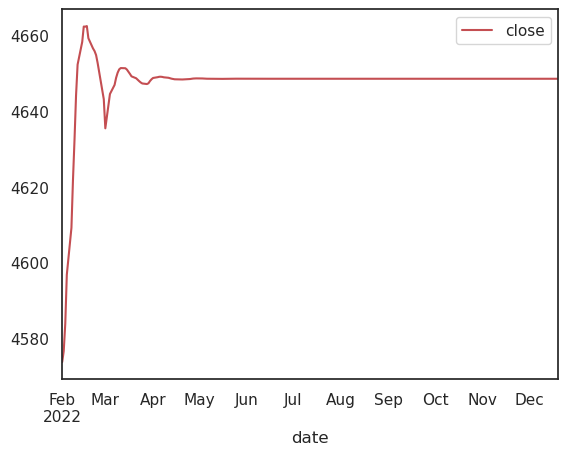

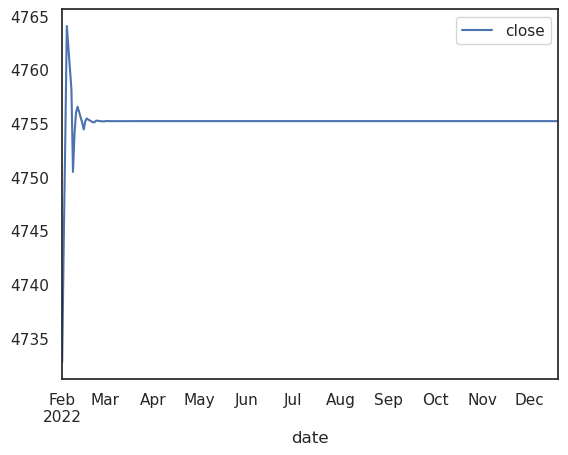

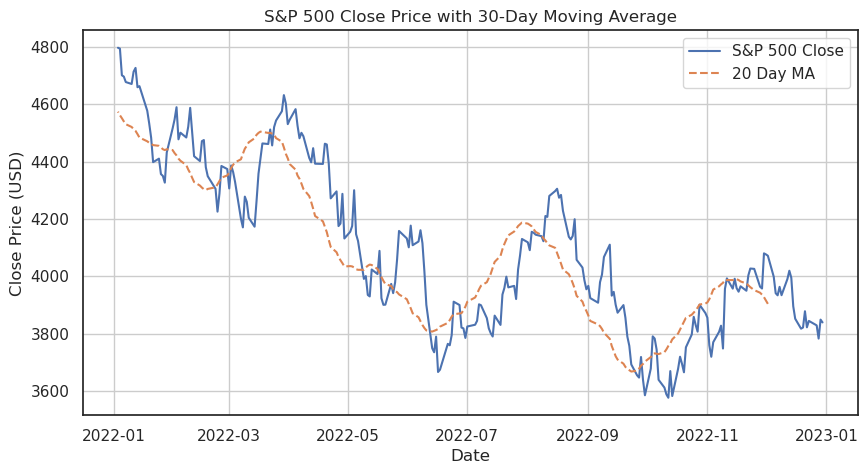

In [28]:
plt.figure(figsize= (15,9))
# data['low'].plot(color = 'g', label = 'Low Price')
predictions_fast.plot(color = 'r', label = 'MA{}'.format(MAF) )
predictions.plot(color = 'b', label = 'MA{}'.format(MAS) )
plt.legend()
plt.show()



#Source: https://medium.com/@wl8380/how-to-create-a-stock-chart-in-python-a-step-by-step-guide-with-aapl-6d6dd2eceb67
#Calculate the 30-Day Moving Average
df['20_MA']= first_year['close'].rolling(window=20).mean()

#Plot
plt.figure(figsize=(10,5))
plt.plot(first_year['close'].to_timestamp(), label = 'S&P 500 Close')
plt.plot(df['20_MA'], label = '20 Day MA', linestyle= '--')
plt.title('S&P 500 Close Price with 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

### Exponential Smoothing

### 1.0 Simple Exponential Smoothing

In [31]:
# Apply Simple Exponential Smoothing
alpha = 0.034
ses_model = SimpleExpSmoothing(data['close']).fit(smoothing_level=alpha, optimized=False)
sesModelAllYear = SimpleExpSmoothing(first_year['close']).fit(smoothing_level=alpha, optimized=False)

# Forecast for the next 10 periods
forecast = ses_model.forecast(firstPredictionLength)
predictionsSES = pd.DataFrame({'date': future_dates.to_period('D'), 'close': forecast}).set_index('date')

SESMAD = calculateMAD(predictionsSES['close'], firstEleven['close'])
print(calculateMSE(predictionsSES['close'], firstEleven['close']))
print(SESMAD, end="\n")
print(calculateTrackingSignal(predictionsSES['close'], firstEleven['close'], SESMAD))

303847.48347502324
480.7623304830102
-230.08470935474014


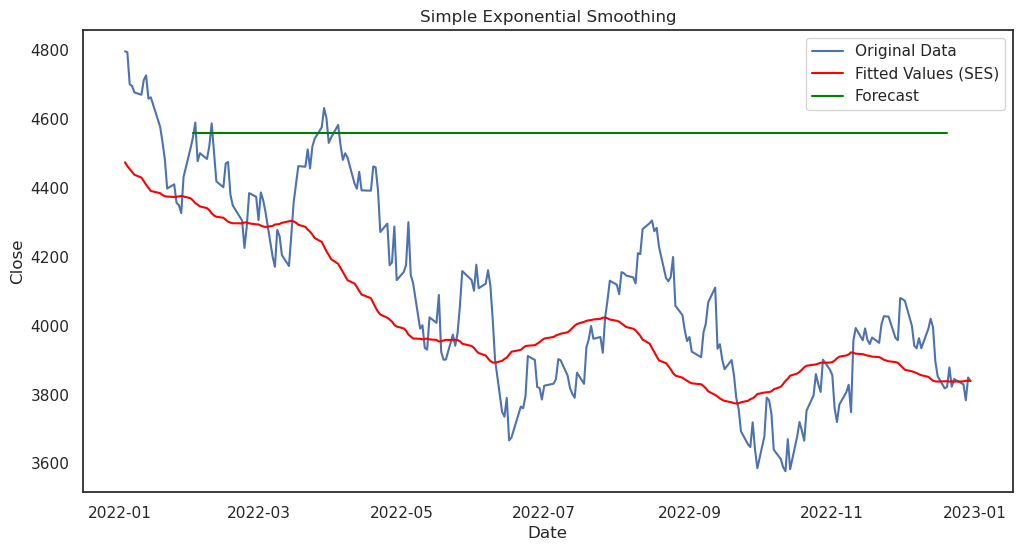

In [32]:
# Plot the original data and the forecast

plt.figure(figsize=(12, 6))
plt.plot(first_year.index.to_timestamp(), first_year['close'], label='Original Data')
plt.plot(sesModelAllYear.fittedvalues, label='Fitted Values (SES)', color='red')
plt.plot(predictionsSES, label='Forecast', color='green')
plt.title('Simple Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

### Double Exponential Smoothing

3587244.702056896
1698.6898390264346


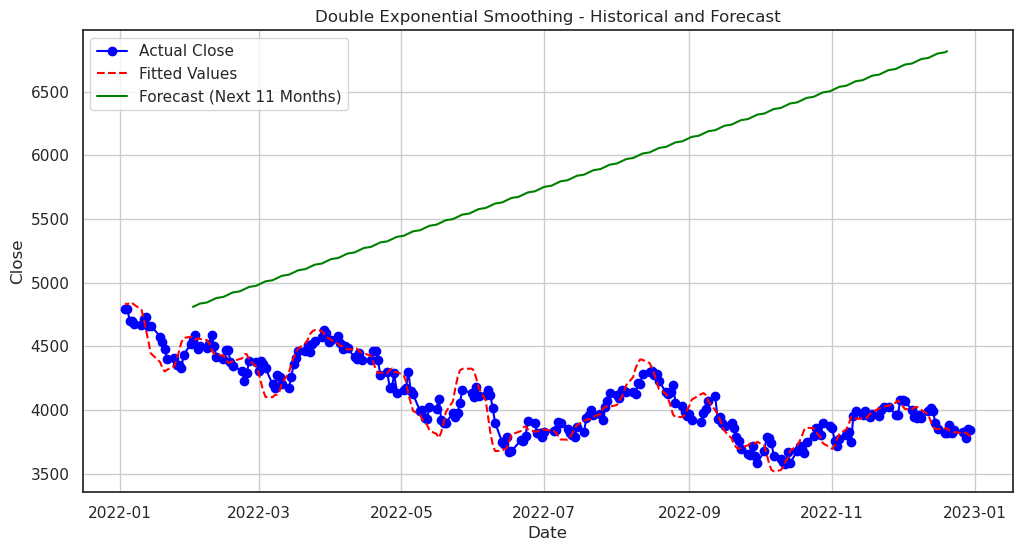

In [34]:
# Fit Double Exponential Smoothing Model
model = sm.tsa.ExponentialSmoothing(data['close'], trend='add')
des_model = model.fit(smoothing_level=0.2, smoothing_slope=0.5)

modelYear = sm.tsa.ExponentialSmoothing(first_year['close'], trend='add')
des_modelYear = modelYear.fit(smoothing_level=0.2, smoothing_slope=0.5)

# Forecast the next 11 months
future_index = pd.date_range(start=data.index[0].to_timestamp() + pd.Timedelta(days=1), periods=firstPredictionLength, freq='B').to_period('D')

# Ensure forecast has the same length as future_index
forecast = des_model.forecast(firstPredictionLength)
forecast_df = pd.DataFrame({'close': forecast.values}, index=future_index)

print(calculateMSE(forecast_df['close'], firstEleven['close']))
print(calculateMAD(forecast_df['close'], firstEleven['close']))

# Plot Historical and Forecasted Data
plt.figure(figsize=(12, 6))
plt.plot(first_year.index.to_timestamp(), first_year['close'], label='Actual Close', marker='o', color='blue')
plt.plot(des_modelYear.fittedvalues.index, des_modelYear.fittedvalues, label='Fitted Values', color='red', linestyle='--')
plt.plot(forecast_df.index, forecast_df['close'], label='Forecast (Next 11 Months)', color='green')
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Double Exponential Smoothing - Historical and Forecast')
plt.legend()
plt.grid()
plt.show()

### Holt's Linear Trend Model

In [36]:
# Apply Holt's Linear Trend Model
# Source: https://www.statology.org/how-to-apply-exponential-smoothing-to-time-series-data-in-python/
# holt_model = ExponentialSmoothing(data['close'], trend='add').fit()

# # Forecast for the next 10 periods
# forecast_holt = holt_model.forecast(firstPredictionLength)
# lieanrHoltsDf = pd.DataFrame({'close': forecast_holt.values}, index=future_index)

# print(calculateMSE(lieanrHoltsDf['close'], firstEleven['close']))
# print(calculateMAD(lieanrHoltsDf['close'], firstEleven['close']))

In [37]:
# Plot the original data and the forecast
# plt.figure(figsize=(12, 6))
# plt.plot(data.index.to_timestamp(), data['close'], label='Original Data')
# plt.plot(holt_model.fittedvalues, label='Fitted Values (Holt)', color='orange')
# plt.plot(lieanrHoltsDf, label='Forecast', color='green')
# plt.title("Holt's Linear Trend Model")
# plt.xlabel('Date')
# plt.ylabel('Low')
# plt.legend()
# plt.show()

### Holt Winter’s Exponential Smoothing (HWES)

In [39]:
data = data.copy()
train = firstMonth
test = firstEleven

def plot_func(forecast1: List[float],
              forecast2: List[float],
              forecast3: List[float],
              title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train.index, y=train['close'], name='Train'))
    fig.add_trace(go.Scatter(x=test.index, y=test['close'], name='Train'))
    fig.add_trace(go.Scatter(x=test.index, y=forecast1, name='Simple'))
    fig.add_trace(go.Scatter(x=test.index, y=forecast2, name="Holt's Linear"))
    fig.add_trace(go.Scatter(x=test.index, y=forecast3, name='Holt Winters'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=700, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Low Volume')
    return fig.show()

In [40]:
train = train.sort_index()
model_simple = SimpleExpSmoothing(train['close']).fit(optimized=True)
forecasts_simple = model_simple.forecast(len(test))

In [41]:
# Fit Holt's model
model_holt = Holt(train['close'], damped_trend=True, initialization_method='estimated').fit(optimized=True)
forecasts_holt = model_holt.forecast(firstPredictionLength)

In [42]:
# Fit Holt-Winters model
model_holt_winters = ExponentialSmoothing(
    train['close'], trend='mul', seasonal='mul', seasonal_periods=10, initialization_method='estimated'
).fit(optimized=True)
forecasts_holt_winters = model_holt_winters.forecast(firstPredictionLength)

forecast_index = pd.date_range(start=train.index[-1].to_timestamp() + pd.Timedelta(days=1), periods=firstPredictionLength, freq='D').to_period('D')
forecast_df = pd.DataFrame({
    'Holt Forecast': forecasts_holt.values,
    'Holt-Winters Forecast': forecasts_holt_winters.values
}, index=forecast_index)

In [43]:
print(model_holt_winters.summary())

print("Holt Forecast: ")
print(calculateMSE(forecast_df['Holt Forecast'], firstEleven['close']))
print(calculateMAD(forecast_df['Holt Forecast'], firstEleven['close']))

print("Holt-Winters Forecast:")
print(calculateMSE(forecast_df['Holt-Winters Forecast'], firstEleven['close']))
print(calculateMAD(forecast_df['Holt-Winters Forecast'], firstEleven['close']))

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    close   No. Observations:                   20
Model:             ExponentialSmoothing   SSE                          30394.189
Optimized:                         True   AIC                            174.525
Trend:                   Multiplicative   BIC                            188.466
Seasonal:                Multiplicative   AICC                           355.859
Seasonal Periods:                    10   Date:                 Sun, 08 Dec 2024
Box-Cox:                          False   Time:                         21:12:08
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9949999                alpha                 True
smoothing_trend          

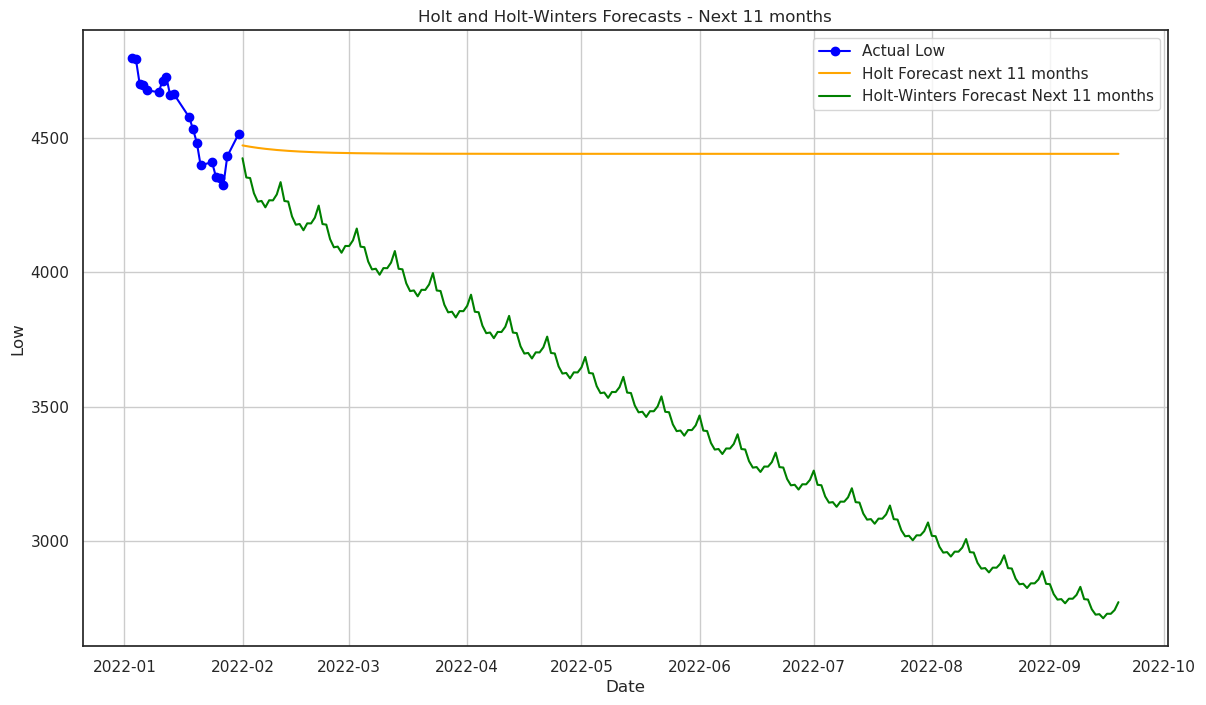

In [44]:
plt.figure(figsize=(14, 8))
plt.plot(train.index.to_timestamp(), train['close'], label='Actual Low', color='blue', marker='o')
plt.plot(forecast_df.index.to_timestamp(), forecast_df['Holt Forecast'], label='Holt Forecast next 11 months', color='orange')
plt.plot(forecast_df.index.to_timestamp(), forecast_df['Holt-Winters Forecast'], label='Holt-Winters Forecast Next 11 months', color='green')

plt.title('Holt and Holt-Winters Forecasts - Next 11 months')
plt.xlabel('Date')
plt.ylabel('Low')
plt.legend()
plt.grid()
plt.show()

# Q3 